In [1]:
import pandas as pd
import numpy as np
import scipy.io 

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(LaCroixColoR)
    library(pals)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

In [3]:
ENMI = scipy.io.loadmat("../data/ENMI_Results/all_benchmark_OCDA_ENMI.mat")['all_ENMI_res'].T
method_columns = ['Infomap', 'SLPA', 'OSLOM_10', 'OSLOM_20', 'OSLOM_30', 'OSLOM_40', 'OSLOM_50', 'OSLOM_60', 'OSLOM_70', 'OSLOM_80', 'OSLOM_90', 'OSLOM_100', 'Clique_3', 'Clique_4', 'Clique_5', 'Clique_6', 'Clique_7', 'Clique_9', 'NNMF_10', 'NNMF_20', 'NNMF_30', 'NNMF_40', 'Louvain']
ENMI_df = pd.DataFrame(ENMI, columns=method_columns)

method_categories = ['Infomap', 'SLPA'] + ['OSLOM'] * 10 + ['Clique'] * 6 + ['NNMF'] * 4 + ['Louvain']
method_category_df = pd.DataFrame({'method': method_columns,
                                   'method_category': method_categories})

# Filter 
method_subset_columns = ['OSLOM_30','OSLOM_90','OSLOM_50','Clique_3','Clique_4','Clique_5','Clique_6','Clique_7','Clique_9','NNMF_10','NNMF_20','NNMF_30','NNMF_40','Infomap','SLPA', 'Louvain']
ENMI_subset_df = ENMI_df[method_subset_columns]

Joining with `by = join_by(OCDA)`


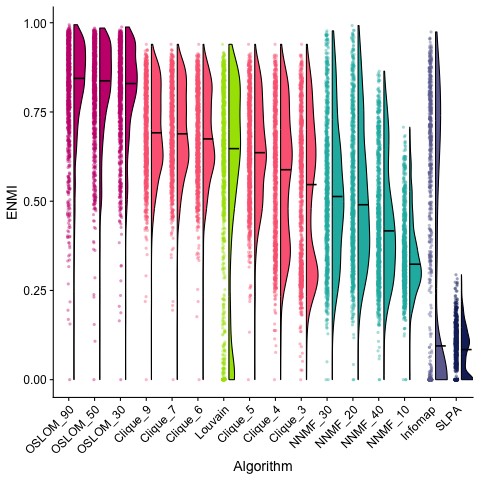

In [4]:
%%R -i ENMI_subset_df,method_subset_columns

ENMI_df_categories <- c(rep("OSLOM", 3), rep("Clique", 6), rep("NNMF", 4), "Infomap", "SLPA", "Louvain")
ENMI_df_categories <- data.frame(OCDA=method_subset_columns, OCDA_Category=ENMI_df_categories)

lacroix_colors <- lacroix_palette("PassionFruit", n=6, type = "discrete")

ENMI_subset_df %>% 
    mutate(iteration_number = row_number()) %>% 
    pivot_longer(cols=c(-iteration_number), names_to="OCDA", values_to="ENMI") %>%
    left_join(ENMI_df_categories) %>%
    mutate(OCDA = fct_reorder(OCDA, ENMI, .fun=median, .desc=TRUE)) %>%
    ggplot(mapping=aes(x=OCDA, y=ENMI, fill=OCDA_Category, color=OCDA_Category)) +
    geom_violinhalf(scale="width", color="black", position = position_nudge(x=0.2), width=0.9)  +
    geom_point(position = position_jitter(width = 0.05, height=0),
                            size = 1.5, alpha=0.4, stroke=0) +
    stat_summary(color="black", fun="median", geom="crossbar", width=0.4, linewidth=0.3, 
            show.legend=FALSE, position = position_nudge(x=0.395)) +
    xlab("Algorithm") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") +
    scale_fill_manual(values=c("OSLOM"=lacroix_colors[1], 
                               "Clique"=lacroix_colors[3],
                               "NNMF"=lacroix_colors[4],
                               "Louvain" =lacroix_colors[2],
                               "Infomap"=lacroix_colors[5],
                               "SLPA"=lacroix_colors[6])) +
    scale_color_manual(values=c("OSLOM"=lacroix_colors[1], 
                               "Clique"=lacroix_colors[3],
                               "NNMF"=lacroix_colors[4],
                               "Louvain" =lacroix_colors[2],
                               "Infomap"=lacroix_colors[5],
                               "SLPA"=lacroix_colors[6])) 

# ggsave("../plots/benchmark_evaluation/ENMI_by_algorithm.svg", width=7.2, height=3.15, units="in")

### Tabular summary of OCDA performances + Louvain for comparison

In [5]:
# Compute median and IQR for each column of ENMI_subset_df
ENMI_summary = (ENMI_df
                .describe()
                .T[['25%', '50%', '75%']]
                .reset_index()
                .rename(columns={'index': 'OCDA', '25%': 'Q1', '50%': 'Median', '75%': 'Q3'})
                .assign(IQR = lambda x: x['Q3'] - x['Q1'])
                [['OCDA', 'Median', 'IQR']]
                .sort_values(by='Median', ascending=False)
                )

ENMI_summary

,OCDA,Median,IQR
10,OSLOM_90,0.844093,0.150814
9,OSLOM_80,0.841697,0.147709
7,OSLOM_60,0.838951,0.153567
8,OSLOM_70,0.838673,0.150160
6,OSLOM_50,0.837393,0.160094
5,OSLOM_40,0.831570,0.153937
4,OSLOM_30,0.829604,0.153895
3,OSLOM_20,0.823149,0.155913
2,OSLOM_10,0.817355,0.168475
11,OSLOM_100,0.793237,0.173915


### Restricting to just the analysis shown in the violin plot

In [8]:
ENMI_summary.query("OCDA in @method_subset_columns").assign(Median=lambda x: x['Median'].round(2),
                                                        IQR=lambda x: x['IQR'].round(2)) 

,OCDA,Median,IQR
10,OSLOM_90,0.84,0.15
6,OSLOM_50,0.84,0.16
4,OSLOM_30,0.83,0.15
17,Clique_9,0.69,0.19
16,Clique_7,0.69,0.19
15,Clique_6,0.67,0.19
22,Louvain,0.65,0.31
14,Clique_5,0.64,0.21
13,Clique_4,0.59,0.32
12,Clique_3,0.55,0.37


### How about sensitivity + specificity?

In [6]:
sensitivity_res = scipy.io.loadmat("../data/ENMI_Results/all_benchmark_OCDA_sensitivity.mat")['all_overlap_sensitivity_res'].T
specificity_res = scipy.io.loadmat("../data/ENMI_Results/all_benchmark_OCDA_specificity.mat")['all_overlap_specificity_res'].T

sensitivity_res_df = pd.DataFrame(sensitivity_res, columns=method_columns)
specificity_res_df = pd.DataFrame(specificity_res, columns=method_columns)

# Compute median and IQR for each column of ENMI_subset_df
sensitivity_summary = (sensitivity_res_df
                .describe()
                .T[['25%', '50%', '75%']]
                .reset_index()
                .rename(columns={'index': 'method', '25%': 'Q1', '50%': 'Median', '75%': 'Q3'})
                .assign(IQR = lambda x: x['Q3'] - x['Q1'])
                [['method', 'Median', 'IQR']]
                .sort_values(by='Median', ascending=False)
                .assign(Statistic = 'Sensitivity')
                )

specificity_summary = (specificity_res_df
                .describe()
                .T[['25%', '50%', '75%']]
                .reset_index()
                .rename(columns={'index': 'method', '25%': 'Q1', '50%': 'Median', '75%': 'Q3'})
                .assign(IQR = lambda x: x['Q3'] - x['Q1'])
                [['method', 'Median', 'IQR']]
                .sort_values(by='Median', ascending=False)
                .assign(Statistic = 'Specificity')
                )

sens_spec_df = pd.concat([sensitivity_summary, specificity_summary]).merge(method_category_df)
sens_spec_df.head()

,method,Median,IQR,Statistic,method_category
0,NNMF_10,1.000000,0.037037,Sensitivity,NNMF
1,NNMF_20,0.923077,0.160000,Sensitivity,NNMF
2,OSLOM_100,0.608696,0.340659,Sensitivity,OSLOM
3,NNMF_30,0.578947,0.207974,Sensitivity,NNMF
4,NNMF_40,0.555556,0.323362,Sensitivity,NNMF


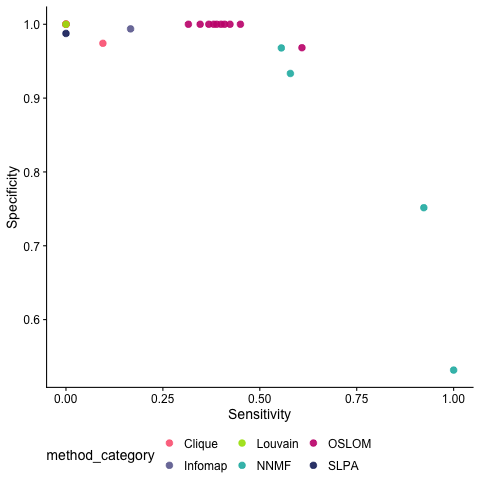

In [28]:
%%R -i sens_spec_df

sens_spec_df %>% 
    dplyr::select(-IQR) %>%
    pivot_wider(names_from=Statistic, values_from=Median) %>% 
    ggplot(data=., mapping=aes(x=Sensitivity, y=Specificity, color=method_category)) +
    geom_point(size=2.75, alpha=0.9) +
    scale_color_manual(values=c("OSLOM"=lacroix_colors[1], 
                               "Clique"=lacroix_colors[3],
                               "NNMF"=lacroix_colors[4],
                               "Louvain" =lacroix_colors[2],
                               "Infomap"=lacroix_colors[5],
                               "SLPA"=lacroix_colors[6])) +
    theme(legend.position='bottom') +
    coord_cartesian()
# ggsave("../plots/benchmark_evaluation/OCDA_sensitivity_vs_specificity.svg", width=3.25, height=3.5, units="in")

In [51]:
# Find the network_number where OSLOM_30 yields the highest ENMI and sensitivity

OSLOM30_diffs_df = ENMI_df.copy().drop(columns=['OSLOM_30']).assign(network_number=ENMI_df.index + 1)

for method in method_columns:
    if method != 'OSLOM_30':
        # Calculate the difference between OSLOM_30 and each method
        OSLOM30_diffs_df[method] = ENMI_df[method] - ENMI_df['OSLOM_30']

# Take the average value across all columns per row
OSLOM30_diffs_df['average_diff'] = OSLOM30_diffs_df.drop(columns=['network_number']).mean(axis=1)
OSLOM30_diffs_df['num_negative'] = (OSLOM30_diffs_df.drop(columns=['network_number', 'average_diff']) < 0).sum(axis=1)
OSLOM30_diffs_df = OSLOM30_diffs_df[['network_number', 'average_diff', 'num_negative']]

In [59]:
sensitivity_res_df_long = sensitivity_res_df.assign(network_number = lambda x: x.index + 1).melt(var_name='method', value_name='Sensitivity', id_vars='network_number')
specificity_res_df_long = specificity_res_df.assign(network_number = lambda x: x.index + 1).melt(var_name='method', value_name='Specificity', id_vars='network_number')

sens_spec_df_long = pd.merge(sensitivity_res_df_long, specificity_res_df_long, on=['network_number', 'method'])
sens_spec_df_long.head()

,network_number,method,Sensitivity,Specificity
0,1,Infomap,0.444444,0.954248
1,2,Infomap,0.000000,1.000000
2,3,Infomap,0.000000,1.000000
3,4,Infomap,0.000000,1.000000
4,5,Infomap,0.000000,1.000000


In [63]:
OSLOM30_sens_spec = sens_spec_df_long.query("method=='OSLOM_30'")

OSLOM30_diffs_df.merge(OSLOM30_sens_spec, on='network_number').sort_values(by='average_diff', ascending=True).head(20)

,network_number,average_diff,num_negative,method,Sensitivity,Specificity
121,122,-0.438347,22,OSLOM_30,0.653846,0.961039
802,803,-0.435208,22,OSLOM_30,0.840000,1.000000
663,664,-0.403714,20,OSLOM_30,0.444444,0.947712
984,985,-0.391605,21,OSLOM_30,0.500000,0.961538
848,849,-0.391105,22,OSLOM_30,0.454545,0.993671
263,264,-0.390750,22,OSLOM_30,0.826087,0.961783
649,650,-0.390542,21,OSLOM_30,0.347826,0.987261
199,200,-0.388992,22,OSLOM_30,0.333333,0.973856
129,130,-0.382247,14,OSLOM_30,0.818182,0.936709
972,973,-0.380855,21,OSLOM_30,0.782609,0.987261
